## DistilRoBERTa

In [ ]:
#!pip install datasets
#!pip install transformers[torch]
#!pip install evaluate
#!pip install transformers
#!pip install 'accelerate>=0.26.0'


In [ ]:
# import packages
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
    

In [3]:
# Load data 
train_df = pd.read_csv("../2_preprocessing/train_case_sensitive.csv")
val_df = pd.read_csv("../2_preprocessing/validation_case_sensitive.csv")
test_df = pd.read_csv("../2_preprocessing/test_case_sensitive.csv")

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)
data = DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset})

In [4]:
# Load DistilRoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("distilroberta-base")

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["script"], padding="max_length", truncation=True)

tokenized_datasets = data.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["script"])  # Remove raw text after tokenization
tokenized_datasets = tokenized_datasets.rename_column("passed_bechdel", "labels")  # Rename for Trainer compatibility
tokenized_datasets.set_format("torch")  # Use PyTorch tensors


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Map:   0%|          | 0/1418 [00:00<?, ? examples/s]

Map:   0%|          | 0/177 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

In [ ]:
#### Overview of possible parameters
# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="steps",       # Evaluate every N steps
#     eval_steps=500,                   # Frequency of evaluation
#     save_steps=500,                   # Frequency of saving checkpoints
#     logging_steps=100,                # Log progress every 100 steps
#     learning_rate=5e-5,               # Adjust learning rate
#     num_train_epochs=5,               # Train for 5 epochs
#     per_device_train_batch_size=16,   # Train batch size
#     per_device_eval_batch_size=16,    # Eval batch size
#     gradient_accumulation_steps=2,    # Simulate larger batch size
#     weight_decay=0.01,                # Apply weight decay
#     fp16=True,                        # Enable mixed precision training
#     warmup_steps=500,                 # Learning rate warmup
#     lr_scheduler_type="cosine",       # Use cosine decay for learning rate
#     save_total_limit=2,               # Save only the last 2 checkpoints
#     load_best_model_at_end=True,      # Load best model at the end of training
#     metric_for_best_model="accuracy", # Use accuracy to determine the best model
#     report_to="none",                 # Disable reporting (e.g., WandB)
# )


In [132]:
results_df = None

In [149]:
# NEW VERSION WITH CROSS VALIDATION!
#random.seed(42)
# Load RobertaForSequenceClassification with DistilRoBERTa's pre-trained weights
model_name = 'distilroberta'
model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)

results_df = pd.DataFrame(columns=[
    "model", "split", "accuracy", "f1_score", "roc_auc", 
    "true_negatives", "true_positives", "false_positives", "false_negatives", "precision", "recall", 
    "true_negative_rate", "false_negative_rate", "false_positive_rate"])

# Define evaluation metrics
def compute_metrics(eval_pred, datasplit):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)

    # Confusion Matrix
    cm = confusion_matrix(labels, predictions)
    tn, fp, fn, tp = cm.ravel()

    # ROC-AUC Score (binary classification assumed)
    roc_auc = roc_auc_score(labels, logits[:, 1])

    # Plot and save confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Failed", "Passed"])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(f"{model_name}, data split: {datasplit}")
    plt.savefig(f'./output/figures/{model_name}_{datasplit}_confusion_matrix.jpeg')
    #plt.savefig(f"./output/figures/distilroberta_confusion_matrix_epoch_{trainer.state.epoch}.png")
    #plt.close()
    plt.show()

    # Append results to DataFrame
    results_df.loc[len(results_df)] = {
        "model": model_name, 
        "split": datasplit, # 
        "accuracy": acc,
        "f1_score": f1, 
        "roc_auc": roc_auc,
        "true_negatives": tn, 
        "true_positives": tp,
        "false_positives": fp,
        "false_negatives": fn, 
        "precision": precision, 
        "recall": recall, 
        "true_negative_rate": tn/(tn+fp), 
        "false_negative_rate": fn/(fn+tp), 
        "false_positive_rate": fp/(fp+tn)
    }

    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Perform cross-validation on the training dataset
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
for train_index, val_index in kf.split(tokenized_datasets["train"]):
    fold += 1
    print(f"Starting fold {fold}...")

    # Split the training data into training and validation splits
    train_split = tokenized_datasets["train"].select(train_index.tolist())
    val_split = tokenized_datasets["train"].select(val_index.tolist())

 # Set up the Trainer for the fold
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir=f"./results/fold_{fold}",
            eval_strategy= "epoch",
            save_strategy= "epoch",
            learning_rate=2e-5,#2e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=3,
            weight_decay=0.01,
            logging_dir=f"./logs/fold_{fold}",
            load_best_model_at_end=True,
            metric_for_best_model="f1",
          #  greater_is_better=True,
            save_total_limit=2,
            seed=42,
           # early_stopping_patience=2,
            #early_stopping_threshold=0.01
        ),
        train_dataset=train_split,
        eval_dataset=val_split,
        processing_class=tokenizer,
        compute_metrics=lambda eval_pred: compute_metrics(eval_pred, datasplit=datasplit_str)
    )


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting fold 1...
Starting fold 2...
Starting fold 3...
Starting fold 4...
Starting fold 5...


/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.686628,0.519435,0.389381,0.618769,0.519435
2,No log,0.617038,0.671378,0.657218,0.704128,0.671378
3,No log,0.592557,0.681979,0.679956,0.686313,0.681979


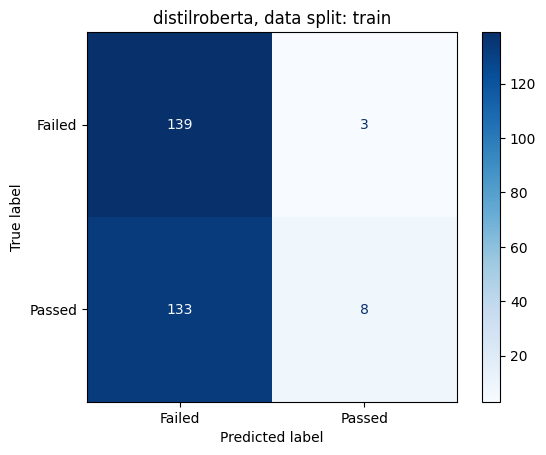

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


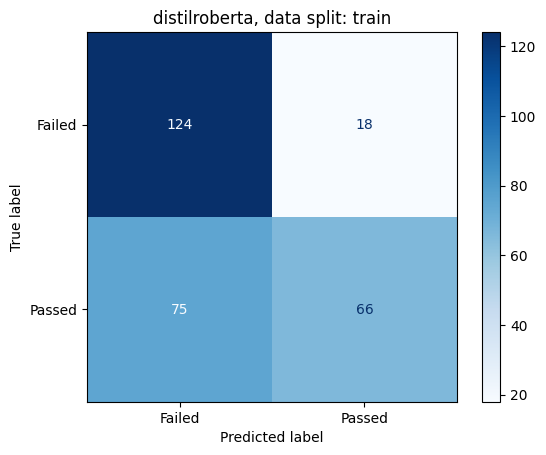

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


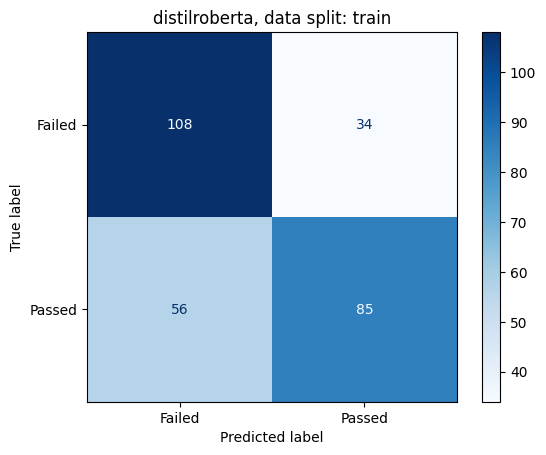

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,distilroberta,train,0.519435,0.389381,0.715713,139,8,3,133,0.618769,0.519435,0.978873,0.943262,0.021127
1,distilroberta,train,0.671378,0.657218,0.742733,124,66,18,75,0.704128,0.671378,0.873239,0.531915,0.126761
2,distilroberta,train,0.681979,0.679956,0.745380,108,85,34,56,0.686313,0.681979,0.760563,0.397163,0.239437


In [150]:
datasplit_str = "train"
trainer.train()
results_df

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


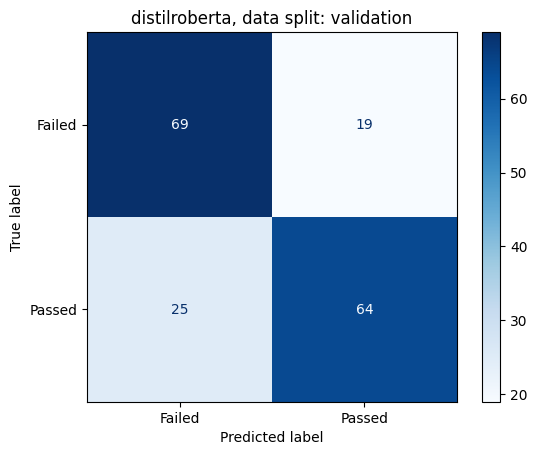


Validation Results After Cross-Validation:
{'eval_loss': 0.5382580161094666, 'eval_accuracy': 0.751412429378531, 'eval_f1': 0.7511741969763255, 'eval_precision': 0.7526680830787991, 'eval_recall': 0.751412429378531, 'eval_runtime': 0.9687, 'eval_samples_per_second': 182.728, 'eval_steps_per_second': 6.194, 'epoch': 3.0}


,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,distilroberta,train,0.519435,0.389381,0.715713,139,8,3,133,0.618769,0.519435,0.978873,0.943262,0.021127
1,distilroberta,train,0.671378,0.657218,0.742733,124,66,18,75,0.704128,0.671378,0.873239,0.531915,0.126761
2,distilroberta,train,0.681979,0.679956,0.745380,108,85,34,56,0.686313,0.681979,0.760563,0.397163,0.239437
3,distilroberta,validation,0.751412,0.751174,0.804137,69,64,19,25,0.752668,0.751412,0.784091,0.280899,0.215909


In [151]:
# After cross-validation, evaluate the final model on the validation and test datasets
datasplit_str = "validation"
validation_results = trainer.evaluate(eval_dataset=tokenized_datasets["validation"])
print("\nValidation Results After Cross-Validation:")
print(validation_results)
results_df

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


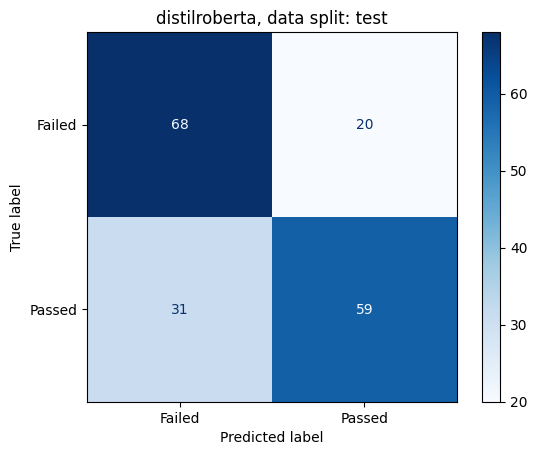


Test Results After Training:


,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,distilroberta,train,0.519435,0.389381,0.715713,139,8,3,133,0.618769,0.519435,0.978873,0.943262,0.021127
1,distilroberta,train,0.671378,0.657218,0.742733,124,66,18,75,0.704128,0.671378,0.873239,0.531915,0.126761
2,distilroberta,train,0.681979,0.679956,0.745380,108,85,34,56,0.686313,0.681979,0.760563,0.397163,0.239437
3,distilroberta,validation,0.751412,0.751174,0.804137,69,64,19,25,0.752668,0.751412,0.784091,0.280899,0.215909
4,distilroberta,test,0.713483,0.712586,0.735480,68,59,20,31,0.717189,0.713483,0.772727,0.344444,0.227273


In [152]:
# Explicitly evaluate the model on the test dataset after training
datasplit_str = "test"
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print("\nTest Results After Training:")
test_results
results_df

In [153]:
# adding to the performance df for plotting 
performance_df = pd.read_csv('/work/classes/NLP_exam/3_model_selection/output/performances_v2.csv')

performance_df_distil = pd.concat([performance_df, results_df], ignore_index=True)
performance_df_distil

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,BoW_log_reg,train,0.793400,0.786900,0.866432,584,541,121,172,0.817221,0.758766,0.828369,0.241234,0.171631
1,BoW_log_reg,validation,0.779700,0.766500,0.867339,74,64,14,25,0.820513,0.719101,0.840909,0.280899,0.159091
2,BoW_log_reg,test,0.702200,0.682600,0.746338,68,57,20,33,0.740260,0.633333,0.772727,0.366667,0.227273
3,BoW_rf,train,0.778600,0.771100,0.866319,575,529,130,184,0.802731,0.741935,0.815603,0.258065,0.184397
4,BoW_rf,validation,0.762700,0.743900,0.850613,74,61,14,28,0.813333,0.685393,0.840909,0.314607,0.159091
5,BoW_rf,test,0.679800,0.650300,0.739899,68,53,20,37,0.726027,0.588889,0.772727,0.411111,0.227273
6,BoW_svc,train,0.809600,0.786100,0.919259,652,496,53,217,0.903461,0.695652,0.924823,0.304348,0.075177
7,BoW_svc,validation,0.757100,0.715200,0.847612,80,54,8,35,0.870968,0.606742,0.909091,0.393258,0.090909
8,BoW_svc,test,0.713500,0.662300,0.763510,77,50,11,40,0.819672,0.555556,0.875000,0.444444,0.125000
9,tf_idf_log_reg,train,0.770100,0.754900,0.833858,590,502,115,211,0.813614,0.704067,0.836879,0.295933,0.163121


In [154]:
performance_df_distil.to_csv('/work/classes/NLP_exam/3_model_selection/output/performances_v3.csv', index = False)


In [155]:
# Save the model and tokenizer
model.save_pretrained("./fine_tuned_distilroberta")
tokenizer.save_pretrained("./fine_tuned_distilroberta")

# Load the model and tokenizer later
#from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
#model = DistilBertForSequenceClassification.from_pretrained("./fine_tuned_distilroberta")
#tokenizer = DistilBertTokenizer.from_pretrained("./fine_tuned_distilroberta")

('./fine_tuned_distilroberta/tokenizer_config.json',
 './fine_tuned_distilroberta/special_tokens_map.json',
 './fine_tuned_distilroberta/vocab.json',
 './fine_tuned_distilroberta/merges.txt',
 './fine_tuned_distilroberta/added_tokens.json')

In [147]:
import seaborn as sns

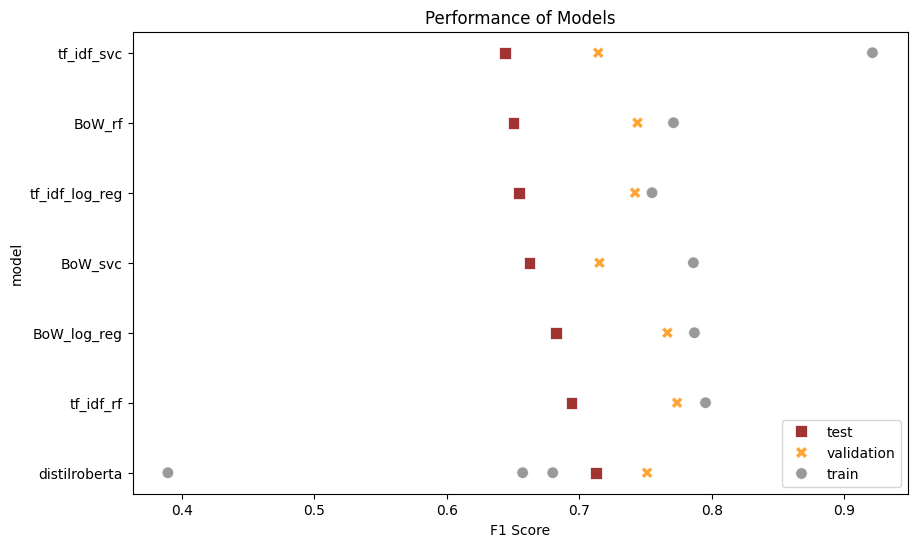

In [ ]:
# make performance plot
# Specify the order of the legend and the icons
order = ['test', 'validation', 'train']
markers = {'test': 's', 'validation': 'X', 'train': 'o'}

# Sort the DataFrame by split and f1_score
performance_df_distil['split_order'] = performance_df_distil['split'].map({v: i for i, v in enumerate(order)})  # Map splits to numeric order
performance_df_sorted = performance_df_distil.sort_values(by=['split_order', 'f1_score'], ascending=[True, True])  # Sort by split order and f1_score

# Plot
fig, ax = plt.subplots(figsize=(10, 6))  # Make wider to show all points
sns.scatterplot(data=performance_df_sorted, 
                y='model', 
                x='f1_score', 
                style='split',
                hue='split', 
                markers=markers,
                palette=['darkred', 'darkorange', 'grey'],
                hue_order=order, 
                style_order=order, 
                s=70,
                alpha=0.8)

# Customize plot
plt.title("Performance of Models")
plt.xlabel("F1 Score")
plt.legend(loc='lower right')  # Adjust legend position

# Remove temporary column used for sorting
performance_df_distil.drop(columns='split_order', inplace=True)
#plt.savefig('../figures/model_performance.jpeg', format='jpeg', dpi=300) 
plt.show()


# Code without CV below

In [89]:
#random.seed(42)
# Load RobertaForSequenceClassification with DistilRoBERTa's pre-trained weights
model_name = 'distilroberta'
model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)  

results_df = pd.DataFrame(columns=[
    "model", "split", "accuracy", "f1_score", "roc_auc", 
    "true_negatives", "true_positives", "false_positives", "false_negatives", "precision", "recall", 
    "true_negative_rate", "false_negative_rate", "false_positive_rate"])

# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)

    # Confusion Matrix
    cm = confusion_matrix(labels, predictions)
    tn, fp, fn, tp = cm.ravel()

    # ROC-AUC Score (binary classification assumed)
    roc_auc = roc_auc_score(labels, logits[:, 1])#, multi_class='ovr')

    # Plot and save confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Failed", "Passed"])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(f"{model_name}, data split: {datasplit}")
    plt.savefig(f'./output/figures/{model_name}_{datasplit}_confusion_matrix.jpeg')
    #plt.savefig(f"./output/figures/distilroberta_confusion_matrix_epoch_{trainer.state.epoch}.png")
    #plt.close()
    plt.show()

    # Append results to DataFrame
    results_df.loc[len(results_df)] = {
        "model": model_name, 
        "split": datasplit, # 
        "accuracy": acc,
        "f1_score": f1, 
        "roc_auc": roc_auc,
        "true_negatives": tn, 
        "true_positives": tp,
        "false_positives": fp,
        "false_negatives": fn, 
        "precision": precision, 
        "recall": recall, 
        "true_negative_rate": tn/(tn+fp), 
        "false_negative_rate": fn/(fn+tp), 
        "false_positive_rate": fp/(fp+tn)
    }

    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",       # Evaluate at the end of each epoch
    save_strategy="epoch",             # Save checkpoint at each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,       # Load the best model based on validation accuracy
    metric_for_best_model="f1", #"accuracy",  # Select best model based on validation accuracy
    save_total_limit=2,                 # Save at most 2 checkpoints
    seed = 42
)

# Set up the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],  # Validation dataset for evaluation
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


If code gives a weird error - restart kernel

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.535536,0.745763,0.745421,0.747423,0.745763
2,No log,0.525712,0.740113,0.740013,0.740671,0.740113
3,No log,0.519690,0.751412,0.751397,0.751573,0.751412


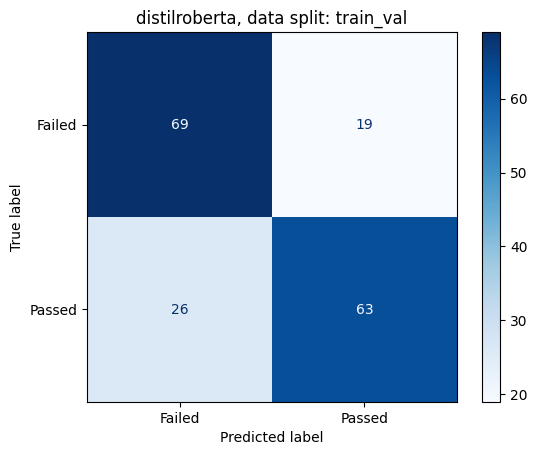

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


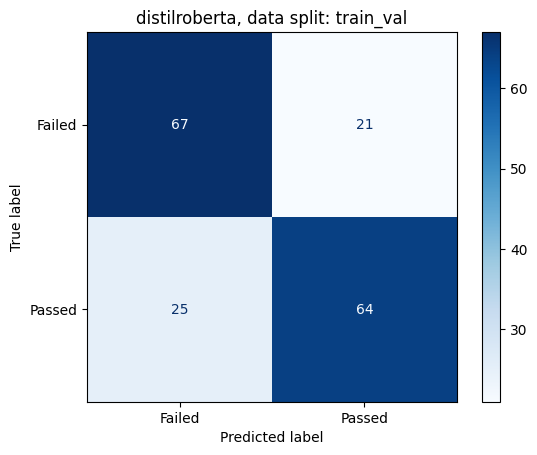

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


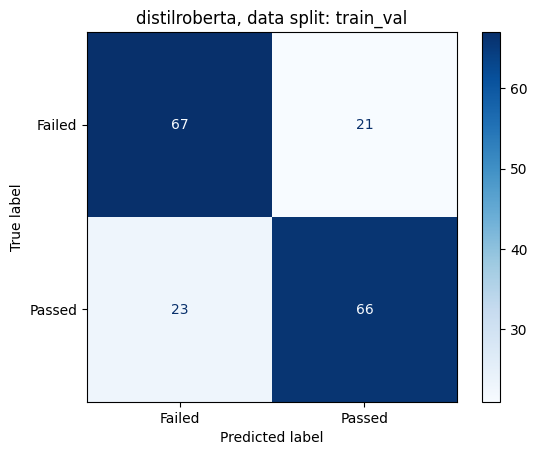

TrainOutput(global_step=135, training_loss=0.6093713265878183, metrics={'train_runtime': 62.5813, 'train_samples_per_second': 67.976, 'train_steps_per_second': 2.157, 'total_flos': 563516313882624.0, 'train_loss': 0.6093713265878183, 'epoch': 3.0})

In [90]:
# Train the model
datasplit = 'train_val'
trainer.train()

In [91]:
results_df

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,distilroberta,train_val,0.745763,0.745421,0.800179,69,63,19,26,0.747423,0.745763,0.784091,0.292135,0.215909
1,distilroberta,train_val,0.740113,0.740013,0.812947,67,64,21,25,0.740671,0.740113,0.761364,0.280899,0.238636
2,distilroberta,train_val,0.751412,0.751397,0.818948,67,66,21,23,0.751573,0.751412,0.761364,0.258427,0.238636


In [ ]:
# drop first two rows to ease plotting later
#results_df.drop(results_df.head(2).index, inplace = False)
results_df = results_df.drop(results_df.head(2).index).reset_index(drop=True)
results_df

In [39]:
# Save the model and tokenizer
model.save_pretrained("./fine_tuned_distilroberta")
tokenizer.save_pretrained("./fine_tuned_distilroberta")

# Load the model and tokenizer later
#from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
#model = DistilBertForSequenceClassification.from_pretrained("./fine_tuned_distilroberta")
#tokenizer = DistilBertTokenizer.from_pretrained("./fine_tuned_distilroberta")


('./fine_tuned_distilroberta/tokenizer_config.json',
 './fine_tuned_distilroberta/special_tokens_map.json',
 './fine_tuned_distilroberta/vocab.json',
 './fine_tuned_distilroberta/merges.txt',
 './fine_tuned_distilroberta/added_tokens.json')

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


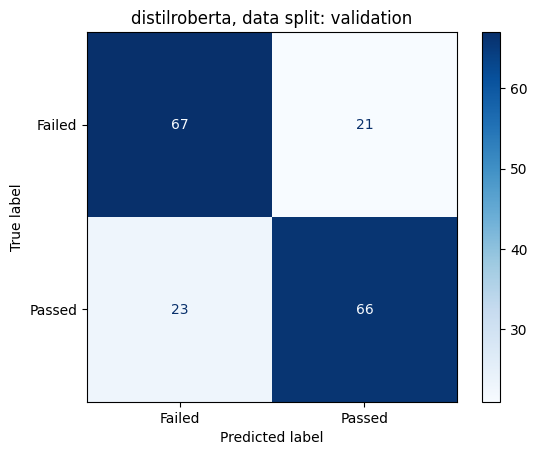


Validation Results After Training:


,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,distilroberta,train_val,0.745763,0.745421,0.800179,69,63,19,26,0.747423,0.745763,0.784091,0.292135,0.215909
1,distilroberta,train_val,0.740113,0.740013,0.812947,67,64,21,25,0.740671,0.740113,0.761364,0.280899,0.238636
2,distilroberta,train_val,0.751412,0.751397,0.818948,67,66,21,23,0.751573,0.751412,0.761364,0.258427,0.238636
3,distilroberta,validation,0.751412,0.751397,0.818948,67,66,21,23,0.751573,0.751412,0.761364,0.258427,0.238636


In [92]:
# Explicitly evaluate the model on the validation dataset after training
datasplit = 'validation'
validation_results = trainer.evaluate(eval_dataset=tokenized_datasets["validation"])
print("\nValidation Results After Training:")
validation_results
results_df


/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


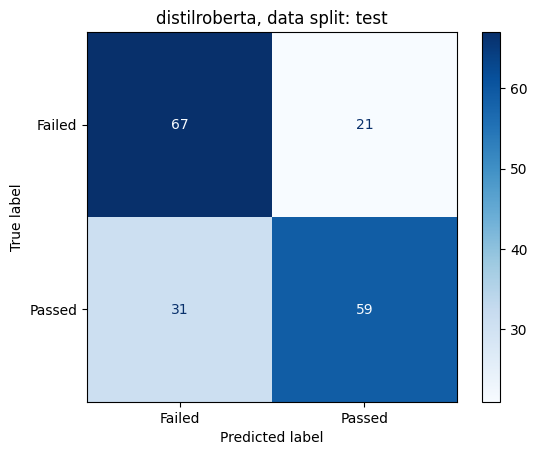


Test Results After Training:


,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,distilroberta,train_val,0.745763,0.745421,0.800179,69,63,19,26,0.747423,0.745763,0.784091,0.292135,0.215909
1,distilroberta,train_val,0.740113,0.740013,0.812947,67,64,21,25,0.740671,0.740113,0.761364,0.280899,0.238636
2,distilroberta,train_val,0.751412,0.751397,0.818948,67,66,21,23,0.751573,0.751412,0.761364,0.258427,0.238636
3,distilroberta,validation,0.751412,0.751397,0.818948,67,66,21,23,0.751573,0.751412,0.761364,0.258427,0.238636
4,distilroberta,test,0.707865,0.707126,0.729798,67,59,21,31,0.710889,0.707865,0.761364,0.344444,0.238636


In [93]:
# Explicitly evaluate the model on the test dataset after training
datasplit = "test"
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print("\nTest Results After Training:")
test_results
results_df

In [ ]:
# adding to the performance df for plotting 
performance_df = pd.read_csv('/work/classes/NLP_exam/3_model_selection/output/performances_v2.csv')

In [75]:
performance_df_distil = pd.concat([performance_df, results_df], ignore_index=True)
performance_df_distil

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,BoW_log_reg,train,0.793400,0.786900,0.866432,584,541,121,172,0.817221,0.758766,0.828369,0.241234,0.171631
1,BoW_log_reg,validation,0.779700,0.766500,0.867339,74,64,14,25,0.820513,0.719101,0.840909,0.280899,0.159091
2,BoW_log_reg,test,0.702200,0.682600,0.746338,68,57,20,33,0.740260,0.633333,0.772727,0.366667,0.227273
3,BoW_rf,train,0.778600,0.771100,0.866319,575,529,130,184,0.802731,0.741935,0.815603,0.258065,0.184397
4,BoW_rf,validation,0.762700,0.743900,0.850613,74,61,14,28,0.813333,0.685393,0.840909,0.314607,0.159091
5,BoW_rf,test,0.679800,0.650300,0.739899,68,53,20,37,0.726027,0.588889,0.772727,0.411111,0.227273
6,BoW_svc,train,0.809600,0.786100,0.919259,652,496,53,217,0.903461,0.695652,0.924823,0.304348,0.075177
7,BoW_svc,validation,0.757100,0.715200,0.847612,80,54,8,35,0.870968,0.606742,0.909091,0.393258,0.090909
8,BoW_svc,test,0.713500,0.662300,0.763510,77,50,11,40,0.819672,0.555556,0.875000,0.444444,0.125000
9,tf_idf_log_reg,train,0.770100,0.754900,0.833858,590,502,115,211,0.813614,0.704067,0.836879,0.295933,0.163121


In [77]:
# save 
performance_df_distil.to_csv('/work/classes/NLP_exam/3_model_selection/output/performances_v3.csv', index = False)


In [ ]:
# make plot! 